# Präsenzversuch zum Laval-Rotor

Name: Erwin Durasow 
Datum: 06.02.2024 
Gruppe: 79

## Forschungsfrage

Inwiefern beeinflussen Variationen der Scheibenanzahl, der Masseverteilung und des Wellendurchmessers die Eigenfrequenz eines Laval-Rotors und welche Auswirkungen haben diese Veränderungen auf die rotordynamische Stabilität und Selbstzentrierung des Systems?

## Erster Versuch: Prüfstand #X
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="images/Versuchsaufbau.jpg" width="500">

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein:

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240123_141001_lavalrotor_02_04"
)  # path to the folder with H5-file and metadata
filename = "data_20240123_141001_lavalrotor_79_04.h5"  # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240123_141001_lavalrotor_02_04/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823ce-82b9-6d4e-a621-60af4e6f5cc1": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240123_141001_lavalrotor_02_04/1ee823ce-82b9-6d4e-a621-60af4e6f5cc1.json"
  },
  "1ee823b6-50dc-6670-aea5-35f6dd717e83": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240123_141001_lavalrotor_02_04/1ee823b6-50dc-6670-aea5-35f6dd717e83.json"
  },
  "1ee8239b-46ec-63dc-8aa4-b8751ac37fd3": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240123_141001_lavalrotor_02_04/1ee8239b-46ec-63dc-8aa4-b8751ac37fd3.json"
  },
  "1ee823d6-3d20-6332-83f5-6876b760dcf3": {
    "type": "sensor",
  

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [4]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)



#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [5]:
importlib.reload(m_postprocessing)  # reload functions

# definieren des Pfades zu den H5 Daten
h5_file_path = f"{path_measurement_folder}/{filename}"


# initialisieren der Datenstrukturen aus der H5-Datei
acc_x = []
acc_y = []
acc_z = []
vec_time = []
rpm = []

with h5py.File(h5_file_path, "r") as file:
    for exp_stamp in file.keys():
        experiment_group = file[exp_stamp]["RawData"]
        
        data_group = experiment_group[uuid_acceleration]
        acc_x_point = np.array(data_group["acceleration_x"])
        acc_y_point = np.array(data_group["acceleration_y"])
        acc_z_point = np.array(data_group["acceleration_z"])
        vec_time_point = np.array(data_group["timestamp"])
        acc_x.append(acc_x_point)
        acc_y.append(acc_y_point)
        acc_z.append(acc_z_point)
        vec_time.append(vec_time_point)
        
        rpm_point = experiment_group[uuid_motor_rpm]["motor_rpm"][()]
        rpm.append(rpm_point/60)

        
acc_magn_inter = []
amplitude_spectrums = []
frequencies = []
for i in range(0,len(acc_x)):
    acc_magn_point = m_postprocessing.get_vec_accel(acc_x[i], acc_y[i], acc_z[i])      
    acc_magn_interpolated = m_postprocessing.interpolation( vec_time[i],acc_magn_point, interpolation_points )
    acc_magn_inter.append(acc_magn_interpolated)
    amplitude_spectrum_point, frequency_point = m_postprocessing.my_fft_scaled(acc_magn_interpolated, interpolation_points)
    amplitude_spectrums.append(amplitude_spectrum_point[1:])
    frequencies.append(frequency_point[1:])
    print(amplitude_spectrum_point)
    




[1.20462481e+01 7.04120131e-04 1.62246755e-03 ... 9.24771304e-04
 2.22609861e-03 2.35082043e-05]
[1.20499051e+01 7.91512747e-04 1.62342728e-03 ... 8.93396372e-04
 3.02380930e-03 1.33969006e-03]
[1.22356746e+01 1.15142714e-03 7.25867394e-03 ... 2.38537549e-03
 9.81531973e-04 4.47453157e-03]
[1.22597795e+01 9.02925191e-03 1.98367185e-03 ... 3.39366516e-03
 9.78878779e-03 3.16109751e-03]
[1.22931940e+01 3.95504035e-03 4.09606979e-03 ... 1.21781638e-02
 1.15454660e-02 2.59296803e-03]
[1.23240130e+01 1.15926750e-02 1.88399028e-02 ... 1.20679685e-02
 5.09942825e-03 1.05110080e-02]
[1.23798197e+01 8.05345613e-03 1.55651772e-02 ... 1.20089002e-02
 4.52756882e-03 2.10899607e-02]
[1.24403398e+01 1.83713300e-02 1.03254540e-02 ... 2.84912825e-03
 9.63901271e-03 4.44361765e-03]
[1.25049435e+01 4.57314578e-03 4.89900816e-03 ... 8.56416144e-03
 4.82604777e-03 2.05135581e-02]
[1.25695643e+01 3.38562278e-03 1.70647523e-02 ... 1.37819129e-02
 1.82840190e-02 5.68059279e-03]
[1.26315452e+01 6.01627355e-03

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

30.200000000000003
30.4
[1.65, 3.4833333333333334, 19.65, 21.633333333333333, 23.183333333333334, 25.1, 26.9, 28.5, 30.4, 31.966666666666665, 33.766666666666666, 35.56666666666667, 5.266666666666667, 7.116666666666666, 8.9, 10.783333333333333, 12.466666666666667, 14.333333333333334, 16.15, 17.883333333333333]
Maximale Amplitude: 0.26362517480311853
Frequenz mit maximaler Amplitude: None
(1000, 20)


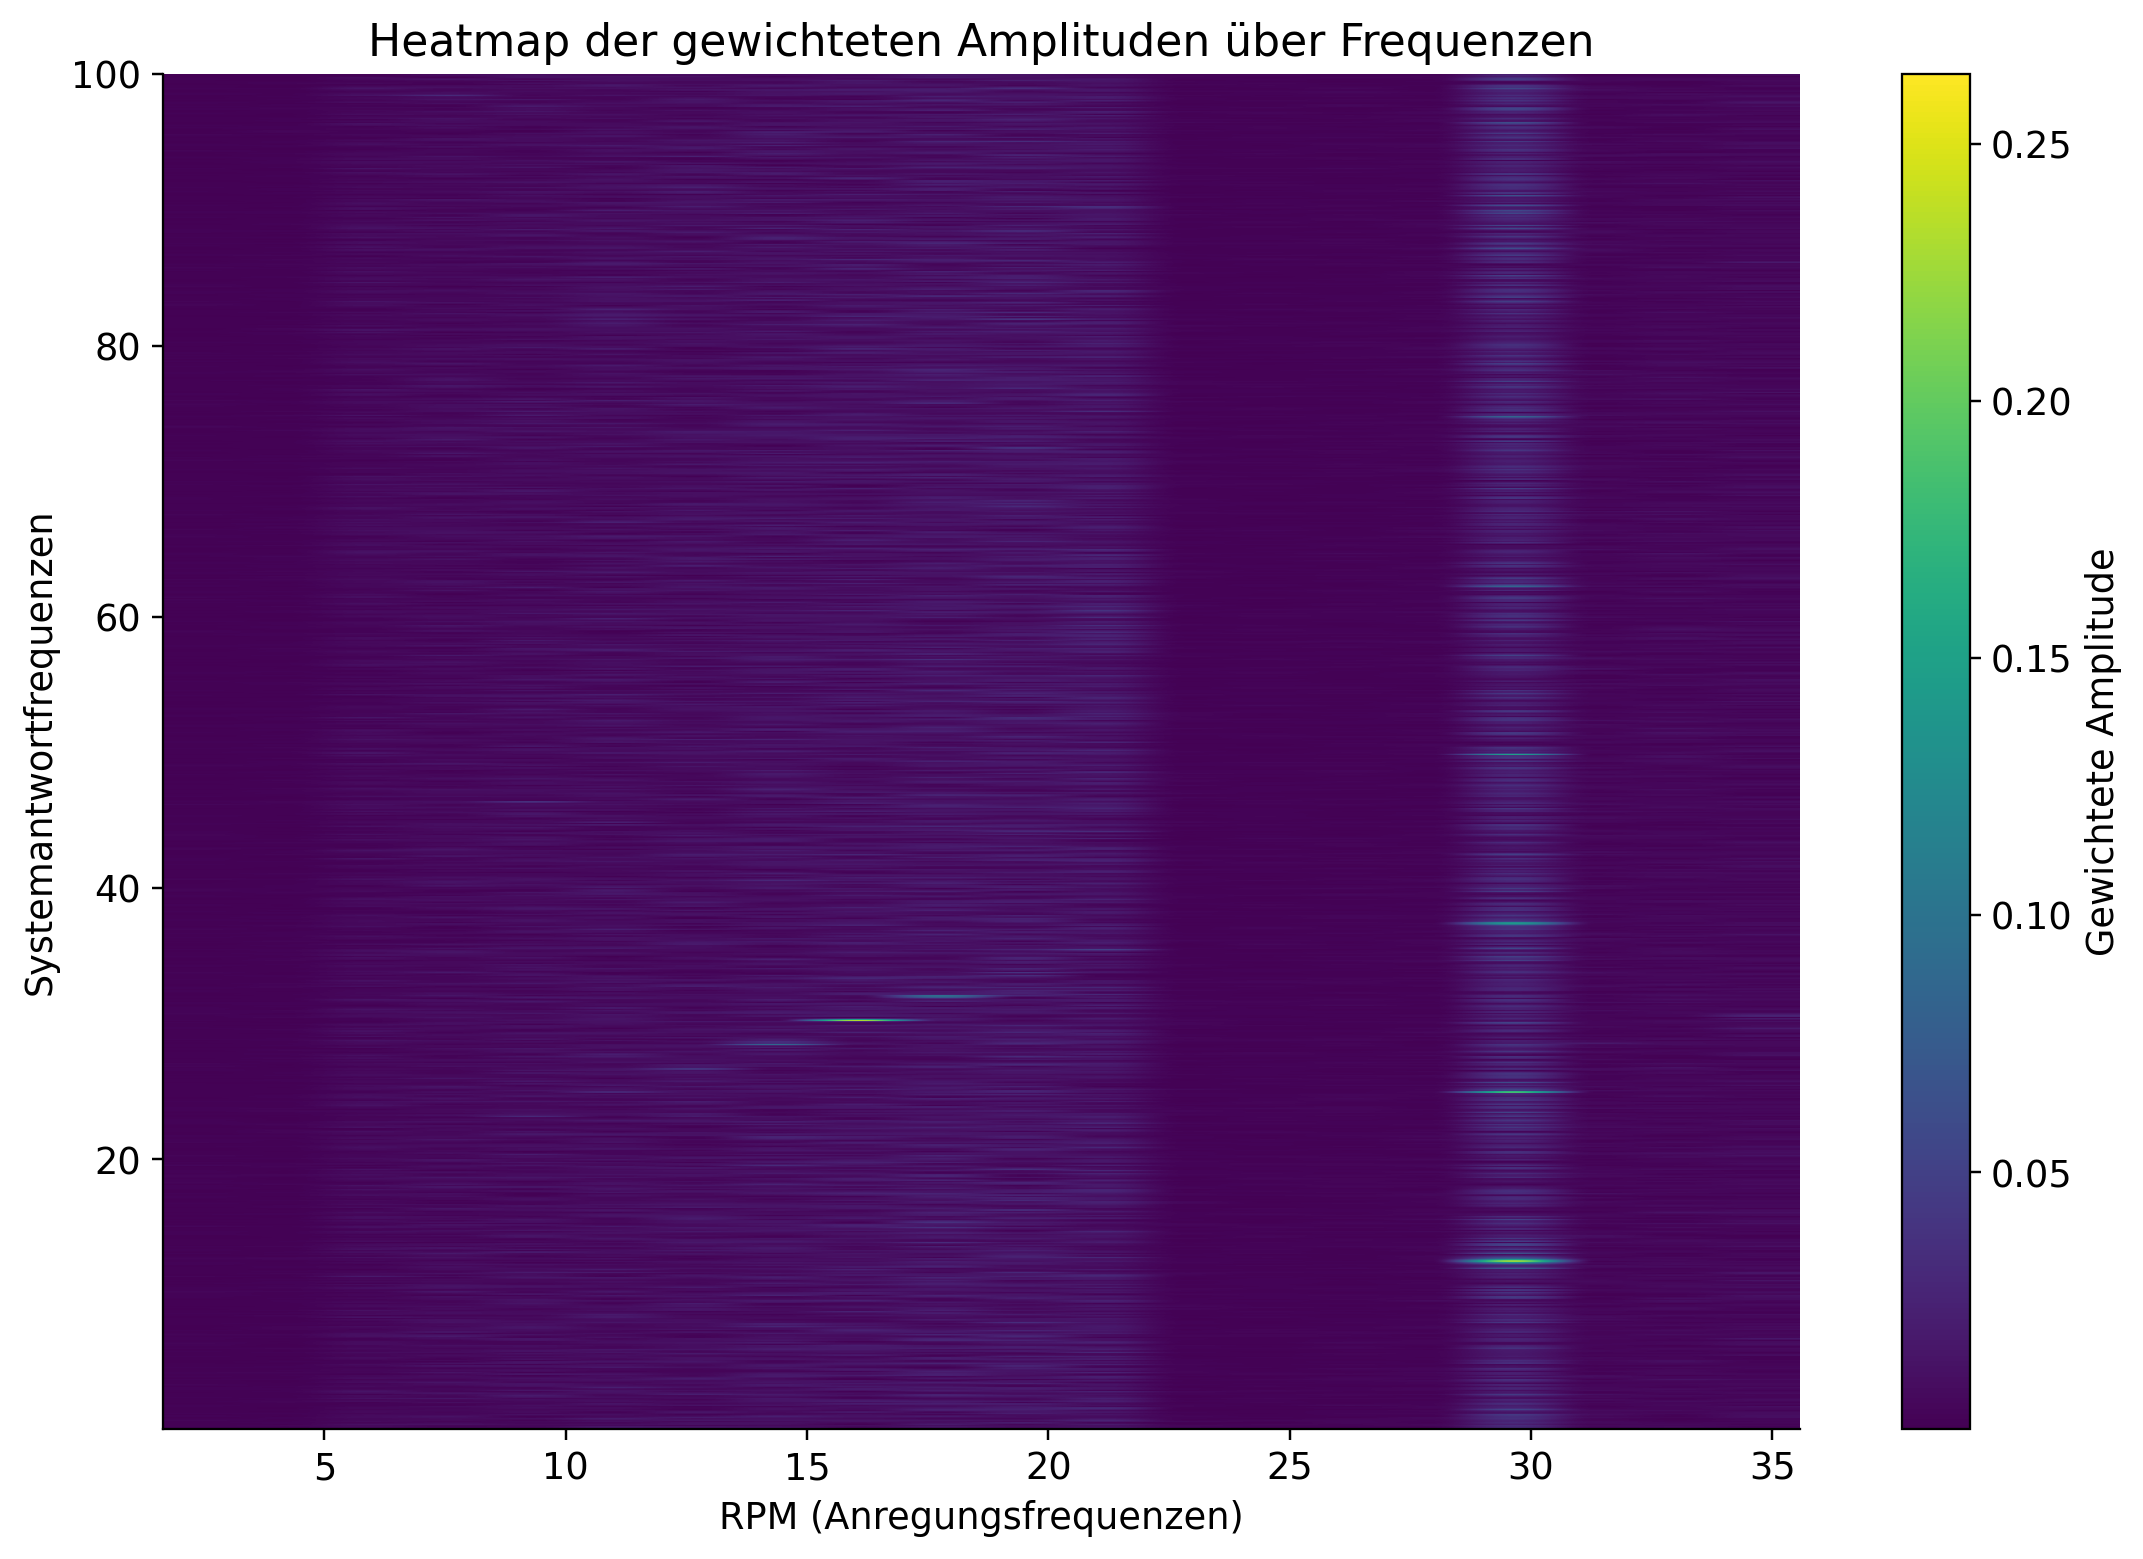

In [16]:

amplitude_spectrums_array = np.array(amplitude_spectrums)
frequencies_array = np.array(frequencies)
rpm_array = np.array(rpm)

experiment_num = int(np.argmax(amplitude_spectrums_array)/1000)
print(frequencies[experiment_num][np.argmax(amplitude_spectrums_array)-experiment_num*1000])
print(rpm_array[experiment_num])
print(rpm)
# Drucken Sie die gefundene maximale Amplitude und die zugehörige Frequenz
print("Maximale Amplitude:", max_amplitude)
print("Frequenz mit maximaler Amplitude:", max_amplitude_frequency)
# Erstellen Sie eine leere Matrix für die Heatmap
heatmap = np.zeros((len(frequencies_array[0]),len(rpm_array) ))
print(heatmap.shape)
# Iterieren Sie über jede Zeile der Heatmap und füllen Sie sie mit den gewichteten Amplitudenwerten
for i in range(len(rpm_array)):
    for j in range(len(frequencies_array[i])):
        heatmap[j, i] += amplitude_spectrums_array[i, j]

# Erstellen Sie das Heatmap-Diagramm
plt.figure(figsize=(12, 8))
plt.imshow(heatmap, aspect='auto', origin='lower', extent=[rpm_array.min(), rpm_array.max(),frequencies_array.min(), frequencies_array.max()], vmin=heatmap.min(), vmax=heatmap.max(), cmap='viridis')
plt.colorbar(label='Gewichtete Amplitude')
plt.xlabel('Anregungsfrequenzen')
plt.ylabel('Systemantwortfrequenzen')
plt.title('Heatmap der gewichteten Amplituden über Frequenzen')
plt.show()

## Zweiter Datensatz: Prüfstand #X

#### 1. Einlesen der Mess- und Metadaten

In [ ]:

path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_100928_lavalrotor_01_02"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_100928_lavalrotor_01_02.h5"  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

#### 2. Verarbeitung der Messdaten

In [ ]:
importlib.reload(m_postprocessing)  # reload functions

# definieren des Pfades zu den H5 Daten
h5_file_path = f"{path_measurement_folder}/{filename}"


# initialisieren der Datenstrukturen aus der H5-Datei
acc_x = []
acc_y = []
acc_z = []
vec_time = []
rpm = []

with h5py.File(h5_file_path, "r") as file:
    for exp_stamp in file.keys():
        experiment_group = file[exp_stamp]["RawData"]
        
        data_group = experiment_group[uuid_acceleration]
        acc_x_point = np.array(data_group["acceleration_x"])
        acc_y_point = np.array(data_group["acceleration_y"])
        acc_z_point = np.array(data_group["acceleration_z"])
        vec_time_point = np.array(data_group["timestamp"])
        acc_x.append(acc_x_point)
        acc_y.append(acc_y_point)
        acc_z.append(acc_z_point)
        vec_time.append(vec_time_point)
        
        rpm_point = experiment_group[uuid_motor_rpm]["motor_rpm"][()]
        rpm.append(rpm_point/60)

        
acc_magn_inter = []
amplitude_spectrums = []
frequencies = []
for i in range(0,len(acc_x)):
    acc_magn_point = m_postprocessing.get_vec_accel(acc_x[i], acc_y[i], acc_z[i])      
    acc_magn_interpolated = m_postprocessing.interpolation( vec_time[i],acc_magn_point, interpolation_points )
    acc_magn_inter.append(acc_magn_interpolated)
    amplitude_spectrum_point, frequency_point = m_postprocessing.my_fft_scaled(acc_magn_interpolated, interpolation_points)
    amplitude_spectrums.append(amplitude_spectrum_point[1:])
    frequencies.append(frequency_point[1:])
    print(max(amplitude_spectrum_point))


#### 3. Darstellung mittels Campbell-Diagramm

In [ ]:

amplitude_spectrums_array = np.array(amplitude_spectrums)
frequencies_array = np.array(frequencies)
rpm_array = np.array(rpm)

# Erstellen Sie eine leere Matrix für die Heatmap
heatmap = np.zeros((len(frequencies_array[0]),len(rpm_array) ))

# Iterieren Sie über jede Zeile der Heatmap und füllen Sie sie mit den gewichteten Amplitudenwerten
for i in range(len(rpm_array)):
    for j in range(len(frequencies_array[i])):
        heatmap[j, i] += amplitude_spectrums_array[i, j]

# Erstellen Sie das Heatmap-Diagramm
plt.figure(figsize=(12, 8))
plt.imshow(heatmap, aspect='auto', origin='lower', extent=[rpm_array.min(), rpm_array.max(),frequencies_array.min(), frequencies_array.max()], vmin=heatmap.min(), vmax=heatmap.max(), cmap='viridis')
plt.colorbar(label='Gewichtete Amplitude')
plt.xlabel('Anregungsfrequenzen')
plt.ylabel('Systemantwortfrequenzen')
plt.title('Heatmap der gewichteten Amplituden über Frequenzen')
plt.show()

## Dritter Datensatz: Prüfstand #X

#### 1. Einlesen der Mess- und Metadaten

In [ ]:

path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_112539_lavalrotor_01_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_112539_lavalrotor_01_03.h5"  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

#### 2. Verarbeitung der Messdaten

In [ ]:
importlib.reload(m_postprocessing)  # reload functions

# definieren des Pfades zu den H5 Daten
h5_file_path = f"{path_measurement_folder}/{filename}"


# initialisieren der Datenstrukturen aus der H5-Datei
acc_x = []
acc_y = []
acc_z = []
vec_time = []
rpm = []

with h5py.File(h5_file_path, "r") as file:
    for exp_stamp in file.keys():
        experiment_group = file[exp_stamp]["RawData"]
        
        data_group = experiment_group[uuid_acceleration]
        acc_x_point = np.array(data_group["acceleration_x"])
        acc_y_point = np.array(data_group["acceleration_y"])
        acc_z_point = np.array(data_group["acceleration_z"])
        vec_time_point = np.array(data_group["timestamp"])
        acc_x.append(acc_x_point)
        acc_y.append(acc_y_point)
        acc_z.append(acc_z_point)
        vec_time.append(vec_time_point)
        
        rpm_point = experiment_group[uuid_motor_rpm]["motor_rpm"][()]
        rpm.append(rpm_point/60)

        
acc_magn_inter = []
amplitude_spectrums = []
frequencies = []
for i in range(0,len(acc_x)):
    acc_magn_point = m_postprocessing.get_vec_accel(acc_x[i], acc_y[i], acc_z[i])      
    acc_magn_interpolated = m_postprocessing.interpolation( vec_time[i],acc_magn_point, interpolation_points )
    acc_magn_inter.append(acc_magn_interpolated)
    amplitude_spectrum_point, frequency_point = m_postprocessing.my_fft_scaled(acc_magn_interpolated, interpolation_points)
    amplitude_spectrums.append(amplitude_spectrum_point[1:])
    frequencies.append(frequency_point[1:])
    print(max(amplitude_spectrum_point))

#### 3. Darstellung mittels Campbell-Diagramm

In [ ]:
amplitude_spectrums_array = np.array(amplitude_spectrums)
frequencies_array = np.array(frequencies)
rpm_array = np.array(rpm)

# Erstellen Sie eine leere Matrix für die Heatmap
heatmap = np.zeros((len(frequencies_array[0]),len(rpm_array) ))
print(amplitude_spectrums_array.shape)
# Iterieren Sie über jede Zeile der Heatmap und füllen Sie sie mit den gewichteten Amplitudenwerten
for i in range(len(rpm_array)):
    for j in range(len(frequencies_array[i])):
        heatmap[j, i] += amplitude_spectrums_array[i, j]

# Erstellen Sie das Heatmap-Diagramm
plt.figure(figsize=(12, 8))
plt.imshow(heatmap, aspect='auto', origin='lower', extent=[rpm_array.min(), rpm_array.max(),frequencies_array.min(), frequencies_array.max()], vmin=heatmap.min(), vmax=heatmap.max(), cmap='viridis')
plt.colorbar(label='Gewichtete Amplitude')
plt.xlabel('Anregungsfrequenzen')
plt.ylabel('Systemantwortfrequenzen')
plt.title('Heatmap der gewichteten Amplituden über Frequenzen')
plt.show()

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Bei diesem Experiment wird deutlich, dass die analytische Lösung viele Randeffekte vernachlässigt und neben dem erwarteten Amplitudenausschlag bei der Durchlaufung der Eigenfrequenz auch weitere Maxima auftreten. Die analytische Lösung liefert daher keine zufriedenstellende Beschreibung des Gesamtverhaltens des realen Systems.

Der Vergleich der gemessenen kritischen Drehzahl mit der analytischen Lösung ist besonders interessant. Beim Durchlaufen einer Anregungsfrequenz von 30 Hz treten Amplitudenmaxima bei 12 Hz Frequenzantwort und ganzzahligen Vielfachen davon auf. Dies legt nahe, dass die Motordrehzahl etwa drei Mal so groß ist wie die Drehzahl der angetriebenen Welle, was auf ein Getriebe zwischen der angetriebenen Welle und dem Motor hinweist. Bei einer Motordrehzahl von ungefähr 30 Hz oder etwa 12 Umdrehungen pro Sekunde der Antriebswelle wird das System mit seiner Eigenfrequenz angeregt, was ein erwartetes Ergebnis ist. Die Amplitudenmaxima bei ganzzahligen Vielfachen der Eigenfrequenz könnten harmonische Schwingungen sein, während die Ausschläge bei 15 Hz Anregungsfrequenz "Subharmonische" darstellen könnten, da das System dort mit der halben Eigenfrequenz angeregt wird.

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

Ein Vergleich zwischen der Resonanzfrequenz von etwa 12 Hz (abgelesen aus dem Campbell-Diagramm) und der berechneten kritischen Drehzahl von 11 Hz zeigt eine realistische Übereinstimmung. Abweichungen können durch verschiedene Gründe wie die Vernachlässigung des Stangengewichts, Reibung und Messungenauigkeiten auftreten.

Beim Betrachten der Campbell-Diagramme anderer Prüfstände fällt auf, dass Amplitudenmaxima bei verschiedenen Anregungs- und Antwortfrequenzen auftreten. Es scheint einen linearen Zusammenhang zwischen Anregungs- und Antwortfrequenz der Maxima zu geben, jedoch ist das genaue Verhalten nicht leicht zu erklären.


## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Insgesamt konnte ich durch dieses Experiment mein Wissen über schwingungsfähige Systeme und die analytische Berechnung von Eigenfrequenzen auffrischen. Ich habe gelernt, warum Campbell-Diagramme für die Veranschaulichung von Antwortamplituden schwingungsfähiger Systeme sinnvoll sind und wie man solche Diagramme erstellt. Darüber hinaus habe ich meine Fähigkeiten im Umgang mit der numpy Bibliothek verbessert, was meine Programmierkenntnisse insgesamt gestärkt hat.